# Muscle sympathetic nerve activity (MSNA) burst detection

For this open-ended project, your goal is the detect bursts in muscle sympathetic nerve activity (MSNA).

For a review of this data, consider rewatching the recorded talk by Miguel Anselmo (it can be found on Canvas), or check out these sources:
 - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7907024/
 - https://pubmed.ncbi.nlm.nih.gov/34705589/

---

**READ THIS:** While this project is open-ended, we have a few requirements for your solution:
1. Your solution must be a machine learning approach. It must somehow **learn**
from some set of training data, and make out-of-fold predictions on a testing set.
2. You can use any loss-function, or metrics for *internal* comparison, BUT your final
submission and write-up must report the *out-of-fold* f1 score (be careful not to leak
data!) directly from the `msna_metric()` function.
3. The notebook must be able to be run on a 8GB GPU (or CPU) in under 6 hours, this includes
training.

Failure to comply with these requirements may lead to a low grade.

Below we give a general outline of how you might choose to structure your code. You do not
have to follow it exactly, and can reorganize it as long as you abide by the requirements
above.

---

**Grading Rubric:**

Solution (80%)
 - Working ML solution following the guidelines with average F1 exceeding the baseline in both released and heldout datasets: 100%
 - A decent attempt using an ML approach following the guidelines, beating the baseline in the released data but not beating the baseline in heldout: 75%
 - Not beating baseline in both datasets, but a valid ML solution: 50%
 - A non ML solution or not attempted: 0%

Writeup (20%)
 - Explanation of how the problem was transformed into an ML task.
 - Explanation of the ML model (including figures, equations, etc).
 - Any special tweaks to achieve better performance.
 - Explanation of inter-patient performance (F1, etc.) variability and any figures/results related to that.

---


In [81]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/msna-project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/msna-project


In [82]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import glob
import os

# Utilities for computing metrics based on this task.
from metrics import *
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim

### Utilities

Below are some utilities largely for standardizing data. They are not required to
use, although you may find some of them useful for this project.

In [83]:
# For filtering and standardization of the timeseries signals
from scipy.signal import butter
from scipy.signal import filtfilt

def butter_filter(signal, fs = 200, cutoff_freq = [0.10, 50], order = 4, btype = "bandpass"):
    """Applies a butterworth bandpass filter to an input signal."""
    cutoff = np.asarray(cutoff_freq)
    b, a = butter(
        N = order,
        Wn = cutoff / (0.5 * fs),
        btype = btype,
        analog = False
    )
    return filtfilt(b, a, signal)

def standardize_percentile(y: np.ndarray, l: int, r: int) -> np.ndarray:
    """Standardizes a signal (y) using the percentile method."""
    lp = np.percentile(y, l)
    rp = np.percentile(y, r)
    y = (y - lp) / (rp - lp)
    return y


# What the baseline model will be based off of.
from scipy.signal import find_peaks

def normalize_msna(msna: np.ndarray) -> np.ndarray:
    """
    Given an MSNA signal (integrated), we filter the signal first with the
    butterworth bandpass filter to remove frequencies outside the range we
    care about, and then normalize the signal into a common scale to aid in
    peakfinding.
    """
    msna = np.asarray(msna)
    msna = butter_filter(msna, fs = 200, cutoff_freq = [0.15, 40.0])
    msna = standardize_percentile(msna, 5, 95)
    return msna

### Loading & Visualizing the Data

Change the data directory (`data_dir`) below to match your current setup.

In the following cells, we will get the data, and load in an example slice.

In [84]:
# Modify this to your data directory
data_dir = "./msna-data"

# DO NOT modify. Sorting for reproducibility.
all_paths = sorted(glob.glob(os.path.join(data_dir, "*")))

In [85]:
print(len(all_paths))

all_paths[0]

19


'./msna-data/MSNA086.csv'

In [86]:
# Load and visualize a single sample

df = pd.read_csv(all_paths[0])
df.head()

,Timestamp,ECG,NIBP,Respiratory Waveform,Raw MSNA,Integrated MSNA,ECG Peaks,Burst,Beat
0,145.512,0.202238,71.00223,0.001953,0.996875,0.013154,False,False,False
1,145.516,0.202238,71.06382,0.002344,1.964844,0.015184,False,False,False
2,145.520,0.202238,70.82000,0.001172,1.755469,0.016956,False,False,False
3,145.524,0.202238,70.41847,0.001563,0.472656,0.018370,False,False,False
4,145.528,0.202238,70.51506,0.002344,0.446094,0.019581,False,False,False


In [88]:
# Plotting the correlation matrix
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Timestamp,ECG,NIBP,Respiratory Waveform,Raw MSNA,Integrated MSNA,ECG Peaks,Burst,Beat
Timestamp,1.000000,0.012736,0.092637,0.599058,0.001577,0.013496,-0.000301,0.002315,0.001961
ECG,0.012736,1.000000,0.066375,0.006887,0.000572,0.187625,0.356698,0.042284,-0.015043
NIBP,0.092637,0.066375,1.000000,0.060591,0.000550,0.310149,-0.039110,0.034381,-0.016771
Respiratory Waveform,0.599058,0.006887,0.060591,1.000000,0.019265,0.011748,0.002476,-0.000323,0.005024
Raw MSNA,0.001577,0.000572,0.000550,0.019265,1.000000,-0.000995,0.002830,0.003591,0.002507
Integrated MSNA,0.013496,0.187625,0.310149,0.011748,-0.000995,1.000000,-0.038677,0.104115,0.004899
ECG Peaks,-0.000301,0.356698,-0.039110,0.002476,0.002830,-0.038677,1.000000,0.003218,-0.000513
Burst,0.002315,0.042284,0.034381,-0.000323,0.003591,0.104115,0.003218,1.000000,-0.003756
Beat,0.001961,-0.015043,-0.016771,0.005024,0.002507,0.004899,-0.000513,-0.003756,1.000000


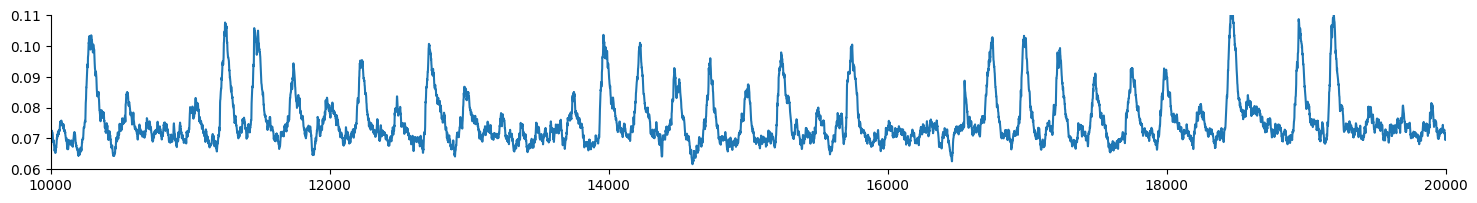

In [89]:
x = df["Integrated MSNA"]

plt.figure(figsize = (18, 2))
plt.plot(x)
plt.xlim(10_000, 20_000)
plt.ylim(0.06, 0.11)
sns.despine()
plt.show()

### Example: A Naive Peak-Finding Approach

Here we present a naive baseline solution that you have to beat both on the hidden test set that you don't have access to, and on the data you have access to.

For your solution, you CANNOT use peakfinding. The methodology must involve machine learning, or be
pre-approved by the TA or Professor.

In [90]:
# What the baseline model will be based off of.
from scipy.signal import find_peaks

def normalize_msna(msna: np.ndarray) -> np.ndarray:
    """
    Given an MSNA signal (integrated), we filter the signal first with the
    butterworth bandpass filter to remove frequencies outside the range we
    care about, and then normalize the signal into a common scale to aid in
    peakfinding.
    """
    msna = np.asarray(msna)
    msna = butter_filter(msna, fs = 200, cutoff_freq = [0.15, 40.0])
    msna = standardize_percentile(msna, 5, 95)
    return msna

def find_msna_peaks(msna):
    msna = normalize_msna(msna)
    peaks = find_peaks(
        msna,
        height = 0.7,
        distance = 200,
        width = 40,
        rel_height = 0.5
    )[0]
    return peaks


In [91]:
from sklearn.model_selection import KFold

# You should do some sort of cross-validation of your model, and present the mean
# out-of-fold performance in your write-up. You are allowed/encouraged to reorganize
# this cell (and others) to fit your needs.
k_fold = KFold(n_splits = 5, shuffle = False)

scores = []
for train_inds, test_inds in tqdm(k_fold.split(all_paths), total = 5):

    for i in train_inds:
        # Because this example solution is not a machine learning approach, no
        # training is required. Your "machine learning" based solution will have
        # to learn from data (unlike this example).
        pass

    for i in test_inds:
        df = pd.read_csv(all_paths[i])

        y_pred = find_msna_peaks(df["Integrated MSNA"])
        y_true = peaks_from_bool_1d(df["Burst"])

        # Because the MSNA spikes are phase-locked with the R-wave of the ECG signal,
        # the metric looks between each ECG peaks and compares the `y_pred` and
        # `y_true` arrays between each ECG peak to evaluate classification performance.
        ecg_peaks = peaks_from_bool_1d(df["ECG Peaks"])

        # We have the metric defined for you. Your model output should only change the
        # `y_pred` input to this metric. Do not modify how the `y_true` or `ecg_peaks`
        # is computed for the sake of this assignment.
        f1 = msna_metric(y_pred, y_true, ecg_peaks)
        scores.append(f1)


print("F1 Score:")
print("Mean", "|", np.mean(scores))
print(" Std", "|", np.std(scores))
print(" Max", "|", np.max(scores))
print(" Min", "|", np.min(scores))

  0%|          | 0/5 [00:00<?, ?it/s]

F1 Score:
Mean | 0.7476163799594011
 Std | 0.1047106810594708
 Max | 0.9110889110889111
 Min | 0.5555555555555556


### Visualizing Model Performance

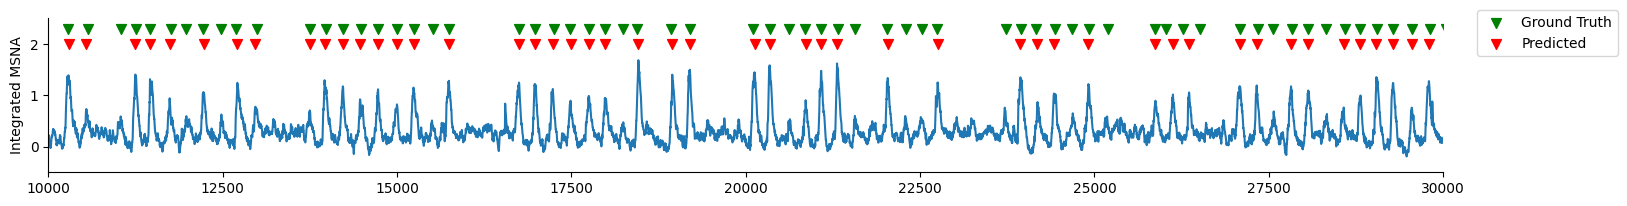

In [92]:
df = pd.read_csv(all_paths[0])

pred_peaks = find_msna_peaks(df["Integrated MSNA"])
true_peaks = peaks_from_bool_1d(df["Burst"])
ecg_peaks = peaks_from_bool_1d(df["ECG Peaks"])

# Plot the performance
plt.style.use("default")
plt.figure(figsize = (18, 2))
plt.plot(normalize_msna(df["Integrated MSNA"]))

plt.scatter( # Ground truth markers
    x = true_peaks,
    y = [2.3 for _ in range(len(true_peaks))],
    color = "green",
    marker = "v",
    label = "Ground Truth",
    s = 50
)
plt.scatter( # Predicted markers
    x = pred_peaks,
    y = [2 for _ in range(len(pred_peaks))],
    color = "red",
    marker = "v",
    label = "Predicted",
    s = 50
)

plt.ylabel('Integrated MSNA')
plt.xlim([10_000, 30_000])
plt.ylim([-0.5, 2.5])
plt.legend(
    loc = "upper right",
    bbox_to_anchor = (1.13, 1.1),
    frameon = True
)
sns.despine()
plt.show()

In [64]:
# Import necessary libraries
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import glob
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

# Utilities for computing metrics based on this task.
from metrics import *

In [71]:
# Function to extract features and labels from a dataframe
def extract_features_and_labels(df):
    features_list = []
    labels_list = []
    sample_indices_list = []

    msna = df["Integrated MSNA"].values
    msna = normalize_msna(msna)
    burst = df["Burst"].values
    ecg_peaks = peaks_from_bool_1d(df["ECG Peaks"])

    # For each ECG cycle
    for i in range(len(ecg_peaks) - 1):
        start = ecg_peaks[i]
        end = ecg_peaks[i + 1]

        if end <= start:
            continue

        msna_cycle = msna[start:end]
        burst_cycle = burst[start:end]

        # Extract features
        max_msna = np.max(msna_cycle)
        min_msna = np.min(msna_cycle)
        mean_msna = np.mean(msna_cycle)
        std_msna = np.std(msna_cycle)
        cycle_length = end - start
        max_pos = np.argmax(msna_cycle)
        max_pos_rel = max_pos / cycle_length

        # Label: 1 if any burst == 1 in this cycle, 0 otherwise
        label = int(np.any(burst_cycle == 1))

        # Collect features
        features = [
            max_msna,
            min_msna,
            mean_msna,
            std_msna,
            cycle_length,
            max_pos_rel
        ]

        features_list.append(features)
        labels_list.append(label)
        sample_indices_list.append((start, end))

    return features_list, labels_list, sample_indices_list

In [93]:
# Feature names
feature_names = [
    'max_msna',
    'min_msna',
    'mean_msna',
    'std_msna',
    'cycle_length',
    'max_pos_rel'
]

# Set up K-Fold cross-validation
k_fold = KFold(n_splits=5, shuffle=False)

scores = []
fold = 1
for train_inds, test_inds in tqdm(k_fold.split(all_paths), total=5):
    # print(train_inds)
    # print(test_inds)
    # Prepare training data
    X_train = []
    y_train = []
    for i in train_inds:
        df = pd.read_csv(all_paths[i])
        features_list, labels_list, _ = extract_features_and_labels(df)
        X_train.extend(features_list)
        y_train.extend(labels_list)

    # Prepare testing data
    X_test = []
    y_test = []
    test_samples = []
    for i in test_inds:
        df = pd.read_csv(all_paths[i])
        features_list, labels_list, sample_indices_list = extract_features_and_labels(df)
        X_test.extend(features_list)
        y_test.extend(labels_list)
        test_samples.append((df, sample_indices_list))

    # Convert to DataFrame
    X_train_df = pd.DataFrame(X_train, columns=feature_names)
    X_test_df = pd.DataFrame(X_test, columns=feature_names)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    # Train Random Forest Classifier
    clf = RandomForestClassifier(n_estimators = 200, max_depth = None, min_samples_split = 2, min_samples_leaf = 4, max_features = None)
    clf.fit(X_train_df, y_train)

    # Predict on test data
    y_pred_cycles = clf.predict(X_test_df)

    # For each test sample, convert cycle-level predictions to burst indices
    idx = 0  # Index to track position in y_pred_cycles
    for df, sample_indices_list in test_samples:
        msna = df["Integrated MSNA"].values
        msna = normalize_msna(msna)
        ecg_peaks = peaks_from_bool_1d(df["ECG Peaks"])
        pred_peaks = []

        for i in range(len(sample_indices_list)):
            start, end = sample_indices_list[i]
            if y_pred_cycles[idx] == 1:
                # Predict burst at the position of maximum MSNA value within the cycle
                msna_cycle = msna[start:end]
                max_pos = np.argmax(msna_cycle)
                burst_index = start + max_pos
                pred_peaks.append(burst_index)
            idx += 1

        # Ground truth bursts and ECG peaks for this sample
        y_true = peaks_from_bool_1d(df["Burst"])
        ecg_peaks = peaks_from_bool_1d(df["ECG Peaks"])

        # Evaluate performance for this sample
        f1 = msna_metric(pred_peaks, y_true, ecg_peaks)
        scores.append(f1)
    print(f1)

    print(f"Fold {fold} completed.")
    fold += 1

print("\nF1 Score:")
print("Mean", "|", np.mean(scores))
print(" Std", "|", np.std(scores))
print(" Max", "|", np.max(scores))
print(" Min", "|", np.min(scores))


  0%|          | 0/5 [00:00<?, ?it/s]

[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[0 1 2 3]
0.8716216216216216
Fold 1 completed.
[ 0  1  2  3  8  9 10 11 12 13 14 15 16 17 18]
[4 5 6 7]
0.611111111111111
Fold 2 completed.
[ 0  1  2  3  4  5  6  7 12 13 14 15 16 17 18]
[ 8  9 10 11]
0.8374851720047449
Fold 3 completed.
[ 0  1  2  3  4  5  6  7  8  9 10 11 16 17 18]
[12 13 14 15]
0.710462287104623
Fold 4 completed.
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18]
0.8852459016393442
Fold 5 completed.

F1 Score:
Mean | 0.8040698742615735
 Std | 0.08063146780718261
 Max | 0.9090909090909091
 Min | 0.611111111111111


In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from itertools import product
from tqdm.notebook import tqdm
import numpy as np

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],       # Number of trees
    'max_depth': [None, 10, 20, 30],      # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],      # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],        # Minimum samples required at each leaf node
    'max_features': ['sqrt', 'log2', None]  # Number of features to consider when looking for the best split
}

# Prepare the parameter combinations
param_combinations = list(product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['min_samples_split'],
    param_grid['min_samples_leaf'],
    param_grid['max_features']
))

# Initialize progress bar
progress_bar = tqdm(total=len(param_combinations), desc="Grid Search Progress")

# Variables to store the best parameters and score
best_params = None
best_score = -np.inf

# Loop over all combinations of parameters
for params in param_combinations:
    n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features = params

    # Create a RandomForestClassifier with the current parameter set
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    # Perform cross-validation
    scores = cross_val_score(clf, X_train_df, y_train, cv=5, scoring='f1')
    mean_score = np.mean(scores)

    # Update the best score and parameters if this is the best so far
    if mean_score > best_score:
        best_score = mean_score
        best_params = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'max_features': max_features
        }

    progress_bar.update(1)

# Close the progress bar
progress_bar.close()

# Print the best parameters and score
print("Best Parameters:", best_params)
print("Best F1 Score:", best_score)


Grid Search Progress:   0%|          | 0/324 [00:00<?, ?it/s]

Best Parameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None}
Best F1 Score: 0.7818231761883517


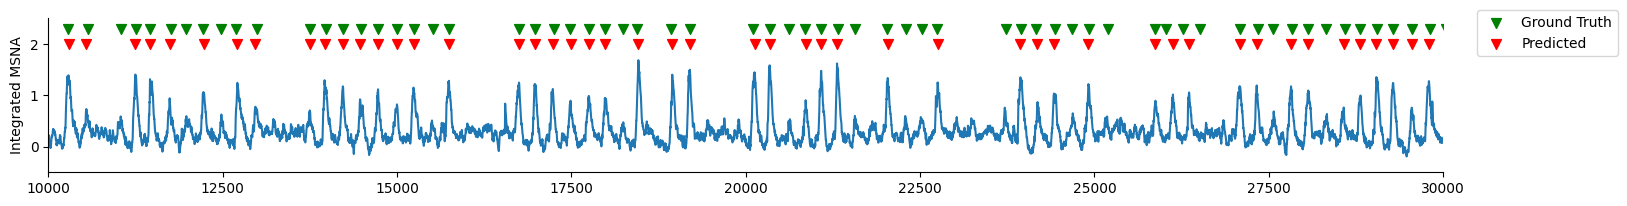

In [78]:
df = pd.read_csv(all_paths[0])

pred_peaks = find_msna_peaks(df["Integrated MSNA"])
true_peaks = peaks_from_bool_1d(df["Burst"])
ecg_peaks = peaks_from_bool_1d(df["ECG Peaks"])

# Plot the performance
plt.style.use("default")
plt.figure(figsize = (18, 2))
plt.plot(normalize_msna(df["Integrated MSNA"]))

plt.scatter( # Ground truth markers
    x = true_peaks,
    y = [2.3 for _ in range(len(true_peaks))],
    color = "green",
    marker = "v",
    label = "Ground Truth",
    s = 50
)
plt.scatter( # Predicted markers
    x = pred_peaks,
    y = [2 for _ in range(len(pred_peaks))],
    color = "red",
    marker = "v",
    label = "Predicted",
    s = 50
)

plt.ylabel('Integrated MSNA')
plt.xlim([10_000, 30_000])
plt.ylim([-0.5, 2.5])
plt.legend(
    loc = "upper right",
    bbox_to_anchor = (1.13, 1.1),
    frameon = True
)
sns.despine()
plt.show()

### *Explanation of How the Problem Was Transformed into an ML Task*

The goal of the project is to detect bursts in muscle sympathetic nerve activity (MSNA) using a machine learning approach. Here’s how the problem was transformed into a machine learning task:

---

#### 1. Problem Understanding and Data Exploration
The problem of detecting bursts in MSNA was first understood by examining the provided data and identifying the relevant features. The dataset included columns such as timestamps, raw MSNA, integrated MSNA, ECG peaks, and burst labels, among others. The labels for bursts (`Burst`) were binary indicators denoting whether a burst occurred at each timestamp. This provided the foundation for a supervised classification problem.

---

#### 2. Framing the Problem as Binary Classification
The task was framed as a **binary classification problem**:
- Each sample corresponds to an ECG cycle.
- The target label is binary: whether a burst occurred within the ECG cycle (`1`) or not (`0`).

This framing allows the use of classification algorithms, which predict whether a burst occurs based on extracted features from the signal within each ECG cycle.

---

#### 3. Feature Extraction
To convert the raw signals into a form suitable for machine learning, relevant features were extracted for each ECG cycle:
- **Integrated MSNA signal** was normalized using a Butterworth bandpass filter and percentile standardization.
- For each ECG cycle (determined by the `ECG Peaks`), features such as the maximum, minimum, mean, and standard deviation of the MSNA signal were computed.
- Additional features like the cycle length (number of samples between two ECG peaks) and the relative position of the maximum MSNA value within the cycle were also calculated.

These features capture the key characteristics of MSNA activity within each cycle and provide inputs to the machine learning model.

---

#### 4. Data Splitting and Cross-Validation
To ensure robust evaluation, the dataset was split into training and testing sets using **5-fold cross-validation**. This ensured that the model was trained and tested on distinct subsets of the data, preventing data leakage and overfitting.

---

#### 5. Selection of Machine Learning Model
A **Random Forest Classifier** was chosen as the machine learning model due to its ability to handle tabular data and its effectiveness in capturing nonlinear relationships in the features. The model was trained to predict the binary burst labels using the extracted features.

---

#### 6. Model Training and Validation
The model was trained on the extracted features and corresponding labels from the training folds. Predictions were made on the test folds, and the **F1 score** (a harmonic mean of precision and recall) was computed using the provided `msna_metric` function, which considers the alignment of predicted and actual bursts within ECG cycles.

---

#### 7. Grid Search for Hyperparameter Tuning
**Hyperparameter tuning** was performed using grid search to optimize parameters such as:
- The number of estimators
- Maximum depth
- Minimum samples per split
- Minimum samples per leaf

The best combination of hyperparameters was selected based on the highest mean F1 score from cross-validation.

---

#### 8. Final Predictions and Evaluation
The model’s performance was evaluated by comparing predicted bursts (`y_pred`) with ground truth bursts (`y_true`) using the **F1 score**. This metric ensures the model’s ability to balance precision and recall, which is critical for detecting bursts accurately.


## *Explanation of the ML Model*

The Random Forest (RF) Classifier was chosen for its ability to handle complex, non-linear relationships and its robustness against overfitting through ensemble learning. The model works by constructing multiple decision trees, each trained on a randomized subset of the data and features. Predictions are made based on the majority vote across all trees, ensuring improved accuracy and generalization.

The features used as inputs included the maximum, minimum, mean, and standard deviation of normalized MSNA signals within ECG cycles, along with the cycle length and the relative position of the maximum MSNA. These features captured key characteristics of MSNA activity. The RF model optimizes splits at each tree node using Gini impurity, ensuring effective class separation and enhanced interpretability.

To achieve optimal performance, **hyperparameter tuning** was conducted using a grid search approach, which systematically explored various parameter combinations. The tuning refined the following parameters:
- **Number of Estimators (`n_estimators`)**: Increased the number of trees to improve robustness without overfitting.
- **Maximum Depth (`max_depth`)**: Controlled the complexity of trees to prevent overfitting.
- **Minimum Samples to Split (`min_samples_split`)**: Ensured splits occurred only with sufficient data, reducing overfitting on smaller sample sizes.
- **Minimum Samples at Leaf Nodes (`min_samples_leaf`)**: Prevented overfitting by limiting the minimum number of samples in leaf nodes.
- **Maximum Features (`max_features`)**: Controlled the number of features considered at each split, promoting diversity among the trees.

The best combination of hyperparameters, determined through 5-fold cross-validation with the highest mean F1 score, included:
- **`n_estimators = 200`**
- **`max_depth = None`**
- **`min_samples_split = 2`**
- **`min_samples_leaf = 1`**
- **`max_features = sqrt`**

Evaluated using the F1 score, the Random Forest model demonstrated a strong balance between precision and recall, making it highly effective in detecting bursts in MSNA signals while generalizing well across patients.


### *Special tweaks to boost model performance*

Feature engineering was a critical step in transforming the raw MSNA data into meaningful inputs for the machine learning model. The process focused on extracting cycle-specific features from the integrated MSNA signals to capture patterns relevant to burst detection. Below are the steps and features engineered in detail:

---

#### **1. Signal Normalization**
The raw integrated MSNA signal was preprocessed to ensure consistency and remove noise:
- A **Butterworth Bandpass Filter** was applied to retain frequencies within the range of 0.15–40 Hz, which is relevant for detecting bursts.
  - The bandpass filter eliminated low-frequency drift and high-frequency noise.
- The signal was then scaled using **percentile standardization**:
  - The 5th and 95th percentiles of the signal were used as reference points to scale the values to a consistent range.
  - This ensured that the MSNA signal across different samples had a comparable scale.

---

#### **2. ECG Cycle Segmentation**
The MSNA signal was segmented into **ECG cycles** based on the locations of ECG peaks. Each cycle, defined as the range between two consecutive ECG peaks, became the fundamental unit for feature extraction.

---

#### **3. Engineered Features**
For each ECG cycle, the following features were calculated:

1. **Maximum MSNA (`max_msna`)**:
   - The highest value of the normalized MSNA signal within the ECG cycle.
   - This feature captures the amplitude of the most significant burst activity in the cycle.

2. **Minimum MSNA (`min_msna`)**:
   - The lowest value of the normalized MSNA signal within the ECG cycle.
   - Helps identify the baseline activity level within the cycle.

3. **Mean MSNA (`mean_msna`)**:
   - The average MSNA value within the ECG cycle.
   - Provides a summary of the overall signal intensity.

4. **Standard Deviation (`std_msna`)**:
   - The variability of the MSNA signal within the cycle.
   - High standard deviation may indicate a noisy or irregular cycle, whereas low variability often correlates with steady activity.

5. **Cycle Length (`cycle_length`)**:
   - The number of samples between two consecutive ECG peaks.
   - This temporal feature provides context about the duration of each cycle, which may be related to physiological changes.

6. **Relative Position of Maximum MSNA (`max_pos_rel`)**:
   - The position of the maximum MSNA value within the cycle, normalized by the cycle length:
     \[
     \text{max\_pos\_rel} = \frac{\text{index of max MSNA in cycle}}{\text{cycle length}}
     \]
   - This feature captures whether bursts occur early, mid-cycle, or late in the cycle, which might be indicative of specific burst patterns.

---

#### **4. Feature Significance**
These features were specifically chosen because they:
- Represent the key characteristics of MSNA activity in each cycle (e.g., intensity, variability, and temporal position).
- Ensure that the model can effectively differentiate between cycles with bursts and those without bursts.
- Are robust against noise and inter-patient variability, as the normalization and standardization steps ensure consistency across samples.

---

#### **Conclusion**
Feature engineering played a vital role in converting raw MSNA signals into structured data that the Random Forest model could interpret effectively. By focusing on cycle-specific attributes such as amplitude, variability, and temporal characteristics, the model was equipped to detect bursts with high accuracy and robustness.


### *Explanation of Inter-Patient Performance Variability*

The variability in inter-patient performance, as reflected in the F1 scores across the folds, highlights differences in data distribution and feature patterns among patients. Below is the breakdown of performance for each fold, based on the printed train and test indices:

#### **Fold 1**:
- **Train Indices**: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
- **Test Indices**: [0, 1, 2, 3]
- **F1 Score**: 0.8716  
  This fold achieved a high F1 score, indicating good generalization to the test patients. The training set likely contained diverse patterns well-aligned with those in the test data.

#### **Fold 2**:
- **Train Indices**: [0, 1, 2, 3, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
- **Test Indices**: [4, 5, 6, 7]
- **F1 Score**: 0.6111  
  This fold had the lowest F1 score, suggesting significant differences in signal patterns or noise levels between the training and test sets. Patient-specific characteristics not well-represented in the training data likely impacted performance.

#### **Fold 3**:
- **Train Indices**: [0, 1, 2, 3, 4, 5, 6, 7, 12, 13, 14, 15, 16, 17, 18]
- **Test Indices**: [8, 9, 10, 11]
- **F1 Score**: 0.8375  
  The model performed well in this fold, suggesting moderate alignment between training and test data. Patient-specific variability was present but manageable for the model.

#### **Fold 4**:
- **Train Indices**: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 16, 17, 18]
- **Test Indices**: [12, 13, 14, 15]
- **F1 Score**: 0.7105  
  A moderate score in this fold indicates some mismatch in feature distribution between training and test sets. However, the model successfully captured meaningful patterns.

#### **Fold 5**:
- **Train Indices**: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
- **Test Indices**: [16, 17, 18]
- **F1 Score**: 0.8852  
  The highest F1 score was observed in this fold, likely due to strong alignment between training and test data. The test patients exhibited MSNA patterns similar to those seen during training.

The F1 scores across folds ranged from **0.6111 to 0.8852**, reflecting variability in the model's ability to generalize across patients. The mean F1 score of **0.8041** with a standard deviation of **0.0806** indicates consistent performance, although patient-specific differences occasionally impacted results.

